## BERT

In [ ]:
!pip install optuna
# Importing required libraries
import pandas as pd
import numpy as np
import re
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model
import optuna
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.6 MB/s eta 0:00:00


### Preprocessing module

In [ ]:
# Loading the data
# train_df = pd.read_csv('../data/agn_train.csv')
# test_df = pd.read_csv('../data/agn_test.csv')

# Loading the data (same as in CNN-RNN model)
train_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv'
test_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv'

train_df = pd.read_csv(train_url, header=None)
test_df = pd.read_csv(test_url, header=None)

# Add column names
train_df.columns = ['Class Index', 'Title', 'Description']
test_df.columns = ['Class Index', 'Title', 'Description']

# Combine 'Title' and 'Description' into 'clean_text'
train_df['clean_text'] = train_df['Title'] + ' ' + train_df['Description']
test_df['clean_text'] = test_df['Title'] + ' ' + test_df['Description']

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function for preprocessing data using the BERT tokenizer
def preprocess_for_bert(texts, max_len):
    """Tokenize and convert text to BERT's input format."""
    return tokenizer(
        texts.tolist(),                # Convert DataFrame to list
        add_special_tokens=True,       # Add [CLS] and [SEP]
        max_length=max_len,            # Max length of the sequence
        truncation=True,               # Truncate if longer than max_len
        padding='max_length',          # Pad to max length
        return_attention_mask=True,    # Create attention mask
        return_tensors='np'            # Return numpy arrays for tensors
    )

# Define the maximum sequence length for BERT
max_len = 128  # BERT typically works well with lengths of 128 or 256 tokens

# Tokenize and preprocess training and test data for BERT
X_train_bert = preprocess_for_bert(train_df['clean_text'], max_len)
X_test_bert = preprocess_for_bert(test_df['clean_text'], max_len)

# Prepare labels
y_train = train_df['Class Index'].values - 1  # Adjust class indices to [0, 1, 2, 3]
y_test = test_df['Class Index'].values - 1  # Adjust class indices to [0, 1, 2, 3]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Training module

In [ ]:
%%time

# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Custom Keras layer to wrap BERT model
class BertLayer(Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        output = self.bert(input_ids, attention_mask=attention_mask)
        return output.pooler_output

# Define inputs for BERT (input_ids, attention_masks)
input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')

# Use the custom BertLayer
bert_output = BertLayer()([input_ids, attention_masks])

# Add a fully connected layer
dense_1 = Dense(128, activation='relu')(bert_output)
dropout_1 = Dropout(0.3)(dense_1)
dense_2 = Dense(64, activation='relu')(dropout_1)
output = Dense(4, activation='softmax')(dense_2)  # 4 classes

# Create the model
model = Model(inputs=[input_ids, attention_masks], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=3e-5)  # Smaller learning rate for fine-tuning BERT
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training parameters
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model
model.fit(
    [X_train_bert['input_ids'], X_train_bert['attention_mask']],
    y_train,
    validation_split=0.1,
    epochs=10,  # Fine-tuning usually requires fewer epochs
    batch_size=16,  # Smaller batch sizes are often used for BERT
    callbacks=[early_stopping],
    verbose=1
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 90s 10ms/step - accuracy: 0.5313 - loss: 1.0916 - val_accuracy: 0.7968 - val_loss: 0.5633
Epoch 2/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.7919 - loss: 0.5732 - val_accuracy: 0.8309 - val_loss: 0.4586
Epoch 3/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.8269 - loss: 0.4809 - val_accuracy: 0.8436 - val_loss: 0.4199
Epoch 4/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.8421 - loss: 0.4396 - val_accuracy: 0.8500 - val_loss: 0.3995
Epoch 5/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - accuracy: 0.8490 - loss: 0.4208 - val_accuracy: 0.8521 - val_loss: 0.3980
Epoch 6/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.8528 - loss: 0.4109 - val_accuracy: 0.8611 - val_loss: 0.3736
Epoch 7/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.8604 - loss: 0.3906 - val_accuracy: 0.8663 - val_loss: 0.3645
Epoch 8/10
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - accuracy: 0.8628 - loss: 

### Hyperparameter selection module

In [ ]:
%%time

# Define a function to create the model with optimized hyperparameters
def model_builder(trial):
    # Hyperparameters to optimize
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    num_units = trial.suggest_int('num_units', 64, 512)

    # Load the pre-trained BERT model
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')

    # Define inputs for the model
    input_ids = Input(shape=(max_len,), dtype='int32', name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype='int32', name='attention_masks')

    # Wrap BERT model in a Lambda layer to handle input compatibility
    def bert_layer(inputs):
        return bert_model(inputs[0], attention_mask=inputs[1]).pooler_output

    bert_output = Lambda(bert_layer, output_shape=(768,))([input_ids, attention_masks])

    # Fully connected layers after BERT
    dense_1 = Dense(num_units, activation='relu')(bert_output)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    output = Dense(4, activation='softmax')(dropout_1)  # 4 classes

    # Create and compile the model
    model = Model(inputs=[input_ids, attention_masks], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function for model evaluation
def objective(trial):
    model = model_builder(trial)

    # Train the model with optimized hyperparameters
    model.fit(
        [X_train_bert['input_ids'], X_train_bert['attention_mask']],
        y_train,
        validation_split=0.1,
        epochs=3,  # Fewer epochs for BERT fine-tuning
        batch_size=16,
        verbose=1
    )

    # Evaluate the model's accuracy
    loss, accuracy = model.evaluate([X_test_bert['input_ids'], X_test_bert['attention_mask']], y_test, verbose=1)
    return accuracy  # Optimizing for accuracy

# Run Optuna to search for the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best trial results
print(study.best_trial)

[I 2024-10-29 08:10:38,424] A new study created in memory with name: no-name-9c7fda32-0ade-406c-8306-c5a6fe156be9
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is

238/238 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8253 - loss: 0.5069


[I 2024-10-29 08:14:22,130] Trial 0 finished with value: 0.828026294708252 and parameters: {'dropout_rate': 0.14459046370578643, 'learning_rate': 1.62100265266498e-05, 'num_units': 158}. Best is trial 0 with value: 0.828026294708252.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertF

238/238 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8378 - loss: 0.4703


[I 2024-10-29 08:18:07,225] Trial 1 finished with value: 0.839078962802887 and parameters: {'dropout_rate': 0.4323114233440256, 'learning_rate': 1.9703029483969364e-05, 'num_units': 420}. Best is trial 1 with value: 0.839078962802887.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a Bert

238/238 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.7628 - loss: 0.7188


[I 2024-10-29 08:21:48,029] Trial 2 finished with value: 0.760921061038971 and parameters: {'dropout_rate': 0.43726047495159276, 'learning_rate': 1.0072122900021898e-05, 'num_units': 64}. Best is trial 1 with value: 0.839078962802887.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a Bert

238/238 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.8463 - loss: 0.4252


[I 2024-10-29 08:25:38,680] Trial 3 finished with value: 0.8510526418685913 and parameters: {'dropout_rate': 0.08149069055481528, 'learning_rate': 3.973451891295633e-05, 'num_units': 377}. Best is trial 3 with value: 0.8510526418685913.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a Be

238/238 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.8356 - loss: 0.4704


[I 2024-10-29 08:29:25,444] Trial 4 finished with value: 0.8323684334754944 and parameters: {'dropout_rate': 0.13284854188017065, 'learning_rate': 2.3009228621175003e-05, 'num_units': 249}. Best is trial 3 with value: 0.8510526418685913.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a B

238/238 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.8338 - loss: 0.4705


[I 2024-10-29 08:33:11,571] Trial 5 finished with value: 0.8385526537895203 and parameters: {'dropout_rate': 0.1738457326078573, 'learning_rate': 1.6415325568764623e-05, 'num_units': 414}. Best is trial 3 with value: 0.8510526418685913.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a Be

238/238 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.8370 - loss: 0.4646


[I 2024-10-29 08:36:58,669] Trial 6 finished with value: 0.839736819267273 and parameters: {'dropout_rate': 0.22886471894606164, 'learning_rate': 3.013358123904021e-05, 'num_units': 106}. Best is trial 3 with value: 0.8510526418685913.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a Ber

238/238 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.8492 - loss: 0.4378


[I 2024-10-29 08:40:46,746] Trial 7 finished with value: 0.8497368693351746 and parameters: {'dropout_rate': 0.367888174854343, 'learning_rate': 3.1200621135833786e-05, 'num_units': 500}. Best is trial 3 with value: 0.8510526418685913.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a Ber

238/238 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.8456 - loss: 0.4321


[I 2024-10-29 08:44:38,154] Trial 8 finished with value: 0.8509210348129272 and parameters: {'dropout_rate': 0.2818535724616733, 'learning_rate': 3.551803930715129e-05, 'num_units': 286}. Best is trial 3 with value: 0.8510526418685913.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a Ber

238/238 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.8290 - loss: 0.4707


[I 2024-10-29 08:48:26,394] Trial 9 finished with value: 0.836710512638092 and parameters: {'dropout_rate': 0.1958298708818494, 'learning_rate': 1.8532696564289428e-05, 'num_units': 393}. Best is trial 3 with value: 0.8510526418685913.


FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.8510526418685913], datetime_start=datetime.datetime(2024, 10, 29, 8, 21, 48, 31101), datetime_complete=datetime.datetime(2024, 10, 29, 8, 25, 38, 679945), params={'dropout_rate': 0.08149069055481528, 'learning_rate': 3.973451891295633e-05, 'num_units': 377}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'learning_rate': FloatDistribution(high=5e-05, log=True, low=1e-05, step=None), 'num_units': IntDistribution(high=512, log=False, low=64, step=1)}, trial_id=3, value=None)
CPU times: user 44min 57s, sys: 58.9 s, total: 45min 56s
Wall time: 37min 47s


### Testing module

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

238/238 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step
Test Accuracy: 0.8574
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1900
           1       0.94      0.94      0.94      1900
           2       0.82      0.78      0.80      1900
           3       0.80      0.85      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600



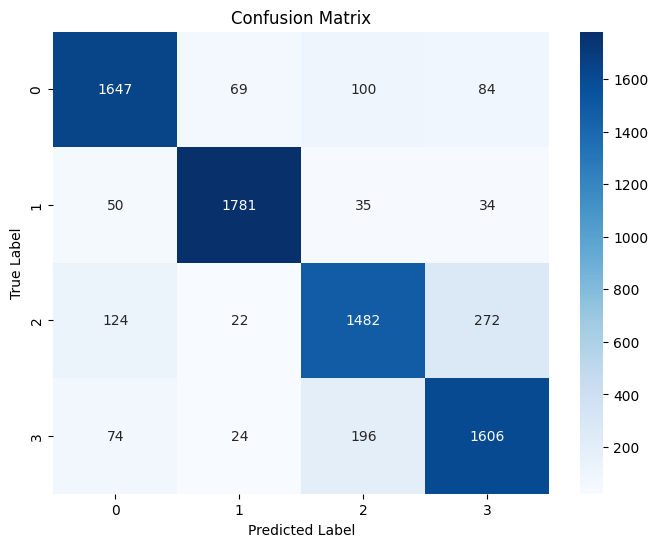

CPU times: user 3min 53s, sys: 5.54 s, total: 3min 58s
Wall time: 3min 43s


In [ ]:
%%time

# Load the best model using the best hyperparameters found by Optuna
best_trial = study.best_trial
best_params = best_trial.params

# Build the model with the best hyperparameters
model = model_builder(best_trial)

# Train the model on the training data
model.fit([X_train_bert['input_ids'], X_train_bert['attention_mask']], y_train,
          validation_split=0.1, epochs=3, batch_size=16, verbose=0)

# Make predictions on the test data
y_pred = model.predict([X_test_bert['input_ids'], X_test_bert['attention_mask']])
y_pred_classes = y_pred.argmax(axis=1)  # Convert predicted probabilities to predicted classes

# Calculate accuracy
test_accuracy = (y_pred_classes == y_test).mean()
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate classification report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
